In [40]:
run '../__init__.py'

In [41]:
import numpy as np
import networkx as nx
import osmnx as ox
import contextily
import shapely

import cvxpy as cp

# import warnings
# warnings.filterwarnings("ignore")

import scipy.io as sio
from sodapy import Socrata

import plotly.graph_objects as go

In [42]:
APP_TOKEN = os.getenv("APP_TOKEN")
client = Socrata("data.cityofnewyork.us", APP_TOKEN, timeout=3600)

# Chelsea: Mapping ATRs onto OSMNX

This notebook tackles the following tasks:
1. Extract NetworkX Directed Graph from a geojson polygon using OSMNX
2. Retrieve Automated Traffic Count data for Chelsea case study
3. Join ATR point data to nearest edge in DiGraph
4. Calculate expressions for inflow and outflow edge volumes

## OSMNX
Extract NetworkX Directed Graph from a geojson polygon using OSMNX

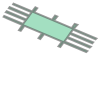

In [43]:
# Shapely polygon describing case study region
polygon = gpd.read_file("chelsea_network.geojson")
polygon = polygon.to_crs(4326)
polygon = polygon.iat[0, 0]
polygon

In [44]:
# create network from that polygon
G = ox.graph_from_polygon(polygon, network_type='drive', simplify=True)

# impute edge (driving) speeds and calculate edge traversal times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

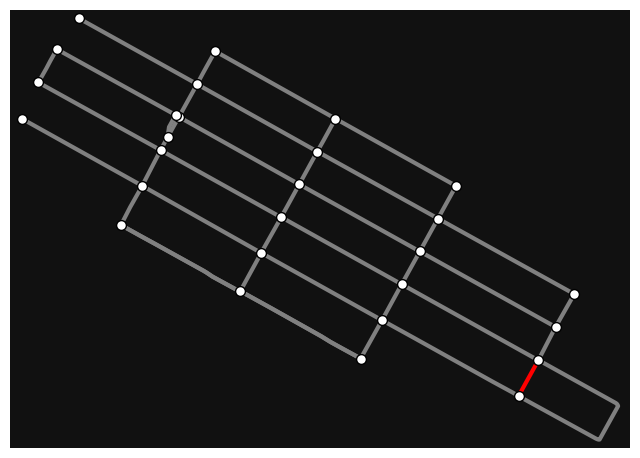

In [45]:
# highlight all parallel (multiple) edges
ec = ["gray" if k == 0 or u == v else "r" for u, v, k in G.edges(keys=True)]
fig, ax = ox.plot_graph(
    G, node_color="w", node_edgecolor="k", node_size=50, edge_color=ec, edge_linewidth=3
)

In [46]:
# you can convert MultiDiGraph to/from geopandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

# Filter edges to ensure that they're all contained within the defined polygon
gdf_edges = gdf_edges[gdf_edges.geometry.within(polygon) == True]

# convert node/edge GeoPandas GeoDataFrames to a NetworkX MultiDiGraph
G = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

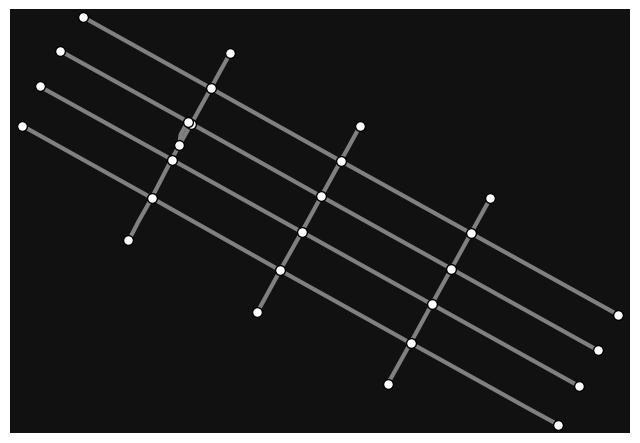

In [47]:
# highlight all parallel (multiple) edges
ec = ["gray" if k == 0 or u == v else "r" for u, v, k in G.edges(keys=True)]
fig, ax = ox.plot_graph(
    G, node_color="w", node_edgecolor="k", node_size=50, edge_color=ec, edge_linewidth=3
)

In [79]:
fig = px.scatter_mapbox(gdf_nodes,
                        size='street_count',
                        lat=gdf_nodes.geometry.y,
                        lon=gdf_nodes.geometry.x,
                        hover_name="highway",
                        mapbox_style="stamen-terrain",
                        width=1000, height=750,
                        zoom=15)
# fig

In [49]:
# convert MultiDiGraph to DiGraph
# choose between parallel edges by minimizing travel_time attribute value
D = ox.get_digraph(G, weight='travel_time')

# Dual graph
D_prime=nx.line_graph(D)

## ATRs

Retrieve Automated Traffic Count data for Chelsea case study

In [50]:
endpoint = "7ym2-wayt"

query = "SELECT COUNT(*)"
NUM_RECORDS = int(client.get(endpoint, query=query)[0]['COUNT'])
NUM_RECORDS

27414481

In [51]:
def request_atr_series(ids):
    
    query = f"""
        SELECT *
        WHERE segmentid IN ({', '.join(map(str, ids))})
        AND yr = 2019
        LIMIT {NUM_RECORDS}
    """
    
    df = pd.DataFrame.from_records(client.get(endpoint, query=query))

    df['ts'] = pd.to_datetime(df[['yr', 'm', 'd', 'hh', 'mm']]\
                 .apply(lambda row: '-'.join(row), axis=1), format='%Y-%m-%d-%H-%M')
    df = df.astype({'vol':float})   
    
    
    gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df.wktgeom, crs="ESRI:102718")).drop(columns=['wktgeom'])
    gdf = gdf.to_crs(4326)
    
    gdf['segment_direction'] = df.segmentid + '-' + df.direction
    
    return gdf

In [1]:
df = request_atr_series([32462, 32285,
                         32467, 32814,
                         32811, 32798, 32795,
                         32628, 32634, 32632,
                         32460, 32458, 271225,
                         32299, 32301, 32463])
print(df.shape)
df.plot()

NameError: name 'request_atr_series' is not defined

## Data Preprocessing

### ATR-to-Graph Spatial Join

Join ATR point data to nearest edge in DiGraph

In [2]:
# match our ATR data (df) to the closest street segment in the OSMNX graph (gdf_edges)
df_mapped = df.to_crs(3857).sjoin_nearest(
    gdf_edges.reset_index().to_crs(3857), distance_col='dist', how='inner'
).drop(columns=['index_right']).to_crs(4326)

df_mapped.groupby(['street', 'fromst', 'tost', 'name']).size()

NameError: name 'df' is not defined

In [54]:
def extract_gdf_coords(gdf):
    """
    For Plotly MapBox plotting
    """
    lats = []
    lons = []
    names = []
    origin_destination = []

    for feature, name, uv in zip(gdf.geometry, gdf.name, gdf.index.droplevel(2)):
        if isinstance(feature, shapely.geometry.linestring.LineString):
            linestrings = [feature]
        elif isinstance(feature, shapely.geometry.multilinestring.MultiLineString):
            linestrings = feature.geoms
        else:
            continue
        for linestring in linestrings:
            x, y = linestring.xy
            
            lats = np.append(lats, y)
            lons = np.append(lons, x)
            names = np.append(names, [name]*len(y))
            origin_destination = np.append(origin_destination, [str(uv)]*len(y))
            
            lats = np.append(lats, None)
            lons = np.append(lons, None)
            names = np.append(names, None)    
            origin_destination = np.append(origin_destination, None)
            
    return lats, lons, names, origin_destination

lats, lons, names, od = extract_gdf_coords(gdf_edges)

In [55]:
# Let's visualize the ATR points against edges and color-code to check that the match

fig = px.line_mapbox(lat=lats, lon=lons, color=names,
                     hover_name=names,
                     width=1000, height=750,
                     mapbox_style="stamen-terrain", zoom=15)

map_colors = {f['legendgroup']: f['line']['color'] for f in fig.data}
df = df_mapped[['name', 'geometry']]
df['color'] = df.name.map(map_colors)

for c in df.color.unique():
    fig.add_trace(go.Scattermapbox(
        mode = "markers",
        lon = df[df.color==c].geometry.x,
        lat = df[df.color==c].geometry.y,
        marker = {'size': 10, 'color': c},
        fillcolor=c,
        name='ATR ' + df[df.color==c].name.iat[0]
    ))
fig.show()

/home/mds377/github/ev-load-forecast-nyc/venv/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Recovering Edge Flows

Calculate expressions for inflow and outflow edge volumes

In [56]:
px.line(df_mapped, x='ts', y='vol', color='segment_direction', line_shape='hv', hover_data=['segmentid'],
        width=1200, height=500)

/home/mds377/github/ev-load-forecast-nyc/venv/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/mds377/github/ev-load-forecast-nyc/venv/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/mds377/github/ev-load-forecast-nyc/venv/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarra

In [57]:
# outflow = df_mapped.groupby(['u', 'v', pd.Grouper(key='ts', freq='D')]).vol.sum().unstack()
outflow = df_mapped.groupby(['u', 'v', pd.Grouper(key='ts', freq='D')]).vol.sum().unstack()

# Add empty rows for edges where there was no ATR data at all
empty_edges = pd.DataFrame(data=None, index=gdf_edges.index.droplevel(2).difference(outflow.index))

outflow = pd.concat([outflow, empty_edges]).sort_index()

In [58]:
# df_mapped['hh'] = df_mapped.hh.astype(int)
# hr_means = df_mapped.groupby('hh').vol.describe()

# outflow = outflow.apply(
#     lambda x: [round(max(np.random.normal(hr_means.loc[x.name.hour]['mean'], hr_means.loc[x.name.hour]['std']), 0)) for i in range(len(x))],
#     axis=0
# )

In [59]:
def recover_edge_inflow(row):
    
    u, v = row.name
    in_edges = list(D.in_edges(u))
    out_edges = list(filter(lambda x: (x[0], x[1]) != (u, v), D.out_edges(u)))
    
    return outflow.loc[in_edges].sum(min_count=1, skipna=False) - outflow.loc[out_edges].sum(min_count=1, skipna=False)

In [60]:
inflow = outflow.apply(recover_edge_inflow, axis=1)

## CVXPY

Minimize $$||\bar{\Omega} \odot (\bar{F} - \bar{F_c})||_F^2 + ||\Omega \odot (F - F_c)||_F^2 + \lambda_1||\bar{F}L'F||_F + \lambda_2||FL'\bar{F}||_F + \lambda_3||\bar{F}(:, t+1) - \bar{F}(:, t)||_F + \lambda_4||F(:, t+1) - F(:, t)||_F + \lambda_5||\bar{F} - F||_F$$
s.t.
1. $F_c, \bar{F_c} > 0$
2. $F_c, \bar{F_c}$ contain integer elements
3. $P(t+1) = P(t) + \bar{F}(t) - F(t)$

In [61]:
# F_in: inflow [veh/t] at given road segments e and times t
F_in = inflow.values
# F_out: outflow [veh/t] at given road segments e and times t
F_out = outflow.values
print(F_in.shape, F_out.shape)

(34, 14) (34, 14)


In [62]:
# Completed versions of F_in and F_out matrices, respectively.
F_in_c = cp.Variable(F_in.shape)
F_out_c = cp.Variable(F_out.shape)
print(F_in_c.shape, F_out_c.shape)

(34, 14) (34, 14)


In [63]:
# Net parking state matrix at time 0 (i.e., initial number of parked cars)
P0 = np.zeros((len(F_in), 1))

In [64]:
# Omegas are binary matrices (with the same dimensions as F_in and F_out, respectively) where each element indicates whether the corresponding element in F_in / F_out is known (1) or unknown (0).
omega_in = ~np.isnan(F_in) * 1
omega_out = ~np.isnan(F_out) * 1

In [65]:
# Regularization parameters that controls the trade-off between fitting the known elements and promoting a low-rank structure.
l1, l2, l3, l4, l5 = 1, 1, 1, 1, 1

In [66]:
# L = nx.directed_laplacian_matrix(D)
L_prime = nx.directed_laplacian_matrix(D_prime, nodelist=list(outflow.index))
L_prime.shape

(34, 34)

$$||\bar{\Omega} \odot (\bar{F} - \bar{F_c})||_F^2 + ||\Omega \odot (F - F_c)||_F^2$$

In [67]:
expr1 = cp.square(cp.atoms.norm(cp.multiply(omega_in, (F_in - F_in_c)), p='fro'))
expr2 = cp.square(cp.atoms.norm(cp.multiply(omega_out, (F_out - F_out_c)), p='fro'))

$$\lambda_1||\bar{F}^\intercal L'F||_F + \lambda_2||F^\intercal L'\bar{F}||_F$$

In [68]:
expr3 = l1 * cp.atoms.norm(F_in.T @ L_prime @ F_out, p='fro')
expr4 = l2 * cp.atoms.norm(F_out.T @ L_prime @ F_in, p='fro')

$$\lambda_3||\bar{F}(:, t+1) - \bar{F}(:, t)||_F + \lambda_4||F(:, t+1) - F(:, t)||_F$$

In [69]:
expr5 = l3 * cp.atoms.norm(F_in[:, 1:] - F_in[:, :-1], p='fro')
expr6 = l4 * cp.atoms.norm(F_out[:, 1:] - F_out[:, :-1], p='fro')

$$\lambda_5||\bar{F} - F||_F$$

In [70]:
expr7 = l5 * cp.atoms.norm(F_in - F_out, p='fro')

1. $F_c, \bar{F_c} > 0$
2. $F_c, \bar{F_c}$ contain integer elements
3. $P(t+1) = P(t) + \bar{F}(t) - F(t)$

In [71]:
# Define the constraints
constraints = [
    F_in_c >= 0,  # Ensure each element of F_in_c is positive
    F_out_c >= 0,  # Ensure each element of F_out_c is positive
    # assert for Parking matrix to be positive
    P0 + cp.cumsum(F_in_c - F_out_c, axis=1) >= 0
]

Minimize

In [72]:
problem = cp.Problem(objective=cp.Minimize(expr1 + expr2 + expr3 + expr4 + expr5 + expr6 + expr7),
                     constraints=constraints)
problem.solve()

/home/mds377/github/ev-load-forecast-nyc/venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1387: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.



nan

In [73]:
# F_in_c.value - F_out_c.value

In [74]:
# P0 + np.cumsum(F_in_c.value - F_out_c.value, axis=1)

In [75]:
pd.DataFrame(np.concatenate([P0, np.round(P0 + np.cumsum(F_in_c.value - F_out_c.value, axis=1))], axis=1))

0        1        2        3        4        5        6        7   \
0   0.0   8043.0   9267.0  10132.0  10942.0  11223.0  11650.0  11773.0   
1   0.0   8816.0  10605.0  11062.0  11183.0  11216.0  11224.0  11226.0   
2   0.0   8816.0  10605.0  11062.0  11183.0  11216.0  11224.0  11226.0   
3   0.0  15375.0  11328.0  11237.0  11219.0  11071.0  11118.0  11402.0   
4   0.0   8816.0  10605.0  11062.0  11183.0  11216.0  11224.0  11226.0   
5   0.0  14565.0  10986.0  10994.0  11716.0  11543.0  11704.0  11150.0   
6   0.0  16498.0  11033.0  10530.0  11114.0  11301.0  11369.0  11442.0   
7   0.0   5666.0  10759.0  11560.0  11166.0  11087.0  11075.0  11148.0   
8   0.0   6273.0   8459.0   9632.0  10297.0  10766.0  11048.0  11082.0   
9   0.0   8816.0  10605.0  11062.0  11183.0  11216.0  11224.0  11226.0   
10  0.0   7418.0   8875.0   9785.0  10696.0  11085.0  11567.0  12032.0   
11  0.0   8816.0  10605.0  11062.0  11183.0  11216.0  11224.0  11226.0   
12  0.0   8816.0  10605.0  11062.0  11183.0  11216.0  11224.0  11226.0   
13  0.0   8073.0   9138.0  10301.0  11037.0  11295.0  11554.0  11388.0   
14  0.0   6718.0   8910.0  10952.0  10917.0  11573.0  11145.0  10650.0   
15  0.0  13200.0  12286.0  11190.0  11398.0  10931.0  11316.0  11899.0   
16  0.0   7886.0   8929.0  10007.0  10672.0  11149.0  11384.0  11532.0   
17  0.0   8439.0   9361.0  10095.0  11445.0  11606.0  11589.0  11486.0   
18  0.0   8816.0  10605.0  11062.0  11183.0  11216.0  11224.0  11226.0   
19  0.0   8816.0  10605.0  11062.0  11183.0  11216.0  11224.0  11226.0   
20  0.0   8816.0  10605.0  11062.0  11183.0  11216.0  11224.0  11226.0   
21  0.0   8822.0   9998.0  10871.0  11454.0  11671.0  11651.0  11336.0   
22  0.0   8816.0  10605.0  11062.0  11183.0  11216.0  11224.0  11226.0   
23  0.0   8816.0  10605.0  11062.0  11183.0  11216.0  11224.0  11226.0   
24  0.0   6157.0   8412.0   9385.0  10288.0  10805.0  11264.0  11486.0   
25  0.0   8816.0  10605.0  11062.0  11183.0  11216.0  11224.0  11226.0   
26  0.0   6675.0   8171.0   9362.0  10054.0  10757.0  11453.0  12323.0   
27  0.0   8816.0  10605.0  11062.0  11183.0  11216.0  11224.0  11226.0   
28  0.0   8816.0  10605.0  11062.0  11183.0  11216.0  11224.0  11226.0   
29  0.0   8196.0   9193.0   9988.0  11216.0  11658.0  11486.0  11389.0   
30  0.0   8816.0  10605.0  11062.0  11183.0  11216.0  11224.0  11226.0   
31  0.0   8816.0  10605.0  11062.0  11183.0  11216.0  11224.0  11226.0   
32  0.0   6730.0   8570.0   9874.0  10742.0  11243.0  11449.0  11708.0   
33  0.0   6029.0   8279.0   9825.0  10580.0  10850.0  11074.0  11272.0   

         8        9        10       11       12       13       14  
0   11500.0  11140.0  11380.0  12187.0  13498.0  19839.0  14458.0  
1   11227.0  11227.0  11227.0  11227.0  11227.0  11227.0  11227.0  
2   11227.0  11227.0  11227.0  11227.0  11227.0  11227.0  11227.0  
3   11441.0  10955.0  11176.0  10922.0  10677.0   6407.0  12793.0  
4   11227.0  11227.0  11227.0  11227.0  11227.0  11227.0  11227.0  
5   11100.0  10044.0   8314.0  10477.0  11028.0  11173.0  11209.0  
6   11759.0  10707.0  10649.0  10464.0   5730.0  13802.0  12121.0  
7   10986.0  11544.0  11641.0  12488.0  21933.0  12178.0  11548.0  
8   11057.0  11159.0  11981.0  12570.0  13769.0  15008.0  22057.0  
9   11227.0  11227.0  11227.0  11227.0  11227.0  11227.0  11227.0  
10  12354.0  12551.0  13712.0  15578.0  18625.0  13367.0  11966.0  
11  11227.0  11227.0  11227.0  11227.0  11227.0  11227.0  11227.0  
12  11227.0  11227.0  11227.0  11227.0  11227.0  11227.0  11227.0  
13  11303.0  11736.0  13423.0  13363.0  12323.0  12465.0  19852.0  
14  10372.0  10122.0  11364.0  11992.0  13282.0  13562.0  20565.0  
15  12081.0  12249.0  11600.0  11473.0  10640.0  11148.0   5773.0  
16  11456.0  11113.0  11826.0  12826.0  13739.0  15165.0  22167.0  
17  11082.0  10975.0  11456.0  12466.0  13420.0  15336.0  12690.0  
18  11227.0  11227.0  11227.0  11227.0  11227.0  11227.0  11227.0  
19  11227.0  11227.0  11227.0  11227.0  11227.0  11227

## Misc

In [76]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

396325.23819879425

In [77]:
# show some basic stats about the network
ox.basic_stats(G, area=graph_area_m, clean_int_tol=15)

/home/mds377/github/ev-load-forecast-nyc/venv/lib/python3.9/site-packages/osmnx/utils_graph.py:508: FutureWarning:

<class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future

/home/mds377/github/ev-load-forecast-nyc/venv/lib/python3.9/site-packages/osmnx/simplification.py:462: UserWarning:

Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/home/mds377/github/ev-load-forecast-nyc/venv/lib/python3.9/site-packages/osmnx/simplification.py:441: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




{'n': 28,
 'm': 34,
 'k_avg': 2.4285714285714284,
 'edge_length_total': 5746.409999999999,
 'edge_length_avg': 169.01205882352937,
 'streets_per_node_avg': 3.892857142857143,
 'streets_per_node_counts': {0: 0, 1: 0, 2: 0, 3: 3, 4: 25},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.0,
  2: 0.0,
  3: 0.10714285714285714,
  4: 0.8928571428571429},
 'intersection_count': 28,
 'street_length_total': 5746.41,
 'street_segment_count': 34,
 'street_length_avg': 169.0120588235294,
 'circuity_avg': 1.000141650057577,
 'self_loop_proportion': 0.0,
 'clean_intersection_count': 1,
 'node_density_km': 70.64904603919112,
 'intersection_density_km': 70.64904603919112,
 'edge_density_km': 14499.22802321672,
 'street_density_km': 14499.228023216723,
 'clean_intersection_density_km': 2.523180215685397}

In [78]:
nx.laplacian_matrix(G.to_undirected())
nx.directed_laplacian_matrix(D).shape

(28, 28)